In [11]:
import numpy as np
import cv2
import os
import pickle
from pathlib import Path
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

# --- I. THAM SỐ CẤU HÌNH ---

BEST_ORIENTATION = 9
SVC_PARAMS = {
    'C': 10,
    'gamma': 'scale',
    'kernel': 'rbf',
    'probability': True
}

IMAGE_RESIZE_SHAPE = (128, 128)
N_COMPONENTS_PCA = 0.95 

# Đã ĐỔI TÊN FILE để phản ánh CHỈ SỬ DỤNG HOG
MODEL_FILENAME = "final_hog_only_pca_svm_model.pkl" 

# --- THIẾT LẬP ĐƯỜNG DẪN DỮ LIỆU ---
FLOWER_DATASET_ROOT = '../flowers' 
TRAIN_DIR = os.path.join(FLOWER_DATASET_ROOT, 'train')
VAL_DIR = os.path.join(FLOWER_DATASET_ROOT, 'val')
TEST_DIR = os.path.join(FLOWER_DATASET_ROOT, 'test')
TRAIN_DATA_DIRS = [TRAIN_DIR, VAL_DIR] 


# --- II. CÁC HÀM TRÍCH XUẤT ĐẶC TRƯNG ---


def extract_hog(img, orientations=BEST_ORIENTATION):
    """Trích HOG feature với tham số cố định."""
    img_resized = cv2.resize(img, IMAGE_RESIZE_SHAPE)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(
        gray,
        orientations=orientations, 
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True,
        channel_axis=None 
    )
    return hog_feat

def extract_combined_features(img_path):
    """Đọc ảnh, trích xuất CHỈ HOG (ĐÃ SỬA)"""
    img = cv2.imread(str(img_path))
    if img is None: return None
    img = np.ascontiguousarray(img)

    hog_feat = extract_hog(img)
    # ĐÃ LOẠI BỎ color_feat = extract_color_hist_hsv(img)
    # ĐÃ LOẠI BỎ features = np.hstack([hog_feat, color_feat])

    features = hog_feat # CHỈ TRẢ VỀ HOG
    return features

def load_and_extract_features(data_dirs, orientations=BEST_ORIENTATION):
    """Tải dữ liệu từ nhiều thư mục và trích xuất đặc trưng."""
    X_features = []
    y_labels = []
    
    class_names = []
    if data_dirs:
        data_path = Path(data_dirs[0])
        class_names = sorted([d.name for d in data_path.iterdir() if d.is_dir()])
    
    for data_dir in data_dirs:
        for class_name in class_names:
            class_path = Path(data_dir) / class_name
            if not class_path.is_dir(): continue
            
            img_files = list(class_path.glob("*.jpg")) 
            
            for img_path in img_files:
                feats = extract_combined_features(img_path)
                
                if feats is not None:
                    X_features.append(feats)
                    y_labels.append(class_name)

    if not X_features:
        return np.array([]), np.array([]), class_names

    le = LabelEncoder()
    y_encoded = le.fit_transform(y_labels) 
    
    return np.array(X_features), y_encoded, le.classes_.tolist()


# --- III. HÀM CHÍNH: HUẤN LUYỆN, LƯU VÀ ĐÁNH GIÁ ---

def train_save_and_evaluate(train_data_dirs, test_data_dir):
    
    # --- BƯỚC 1: HUẤN LUYỆN VÀ LƯU PIPELINE ---
    print("=========== BƯỚC 1: HUẤN LUYỆN VÀ LƯU PIPELINE ===========")
    
    # 1. Tải và Trích xuất Đặc trưng (Gộp Train và Val)
    X_train_full, y_train_full, class_names = load_and_extract_features(train_data_dirs)
    if X_train_full.size == 0:
        print("❌ Lỗi: Không tìm thấy dữ liệu huấn luyện.")
        return

    print(f"✅ Đã tải {X_train_full.shape[0]} mẫu. Kích thước vector gốc: {X_train_full.shape[1]}")
    
    # 2. Chuẩn hóa (StandardScaler)
    scaler = StandardScaler()
    X_train_full_scaled = scaler.fit_transform(X_train_full) 

    # 3. Giảm chiều (PCA)
    print(f"✅ Đang fit PCA (N={N_COMPONENTS_PCA} components, Solver='full')...")
    pca = PCA(n_components=N_COMPONENTS_PCA, random_state=42) 
    X_train_full_pca = pca.fit_transform(X_train_full_scaled)
    
    print(f"✅ Kích thước vector sau PCA: {X_train_full_pca.shape[1]}")

    # 4. Huấn luyện SVM
    svm_model = SVC(**SVC_PARAMS, random_state=42)
    svm_model.fit(X_train_full_pca, y_train_full)
    
    # 5. Đóng gói và Lưu Model
    pipeline_data = {
        "model": svm_model,
        "scaler": scaler,
        "pca": pca,
        "class_names": class_names,
        "orientations": BEST_ORIENTATION,
        "img_size": IMAGE_RESIZE_SHAPE
    }
    with open(MODEL_FILENAME, 'wb') as f:
        pickle.dump(pipeline_data, f)
    print(f"   ✅ Pipeline đã được lưu thành công vào: {MODEL_FILENAME}")
    
    # --- BƯỚC 2: ĐÁNH GIÁ TRÊN TẬP TEST ---
    print("\n=========== BƯỚC 2: ĐÁNH GIÁ TRÊN TẬP TEST ===========")
 
    # 1. Tải và Trích xuất Đặc trưng Test
    X_test, y_test, _ = load_and_extract_features([test_data_dir], BEST_ORIENTATION)

    if X_test.size == 0:
        print("❌ Lỗi: Không tìm thấy dữ liệu test để đánh giá.")
        return

    # 2. Áp dụng Preprocessing (CHỈ TRANSFORM)
    X_test_scaled = scaler.transform(X_test)
    X_test_pca = pca.transform(X_test_scaled)

    # 3. Dự đoán và Đánh giá
    y_pred = svm_model.predict(X_test_pca)

    acc = accuracy_score(y_test, y_pred)

    report = classification_report(
        y_test, 
        y_pred, 
        target_names=class_names, 
        zero_division=0,
        digits=4
    )

    print(f"✅ Test Accuracy: {acc:.4f}")
    print("\nBáo cáo chi tiết (Classification Report):")
    print(report)


# --- IV. THỰC THI ---

if __name__ == '__main__':
    # Kiểm tra đường dẫn cần thiết
    if not os.path.exists(TRAIN_DIR) or not os.path.exists(TEST_DIR):
        print("🛑 LỖI CẤU HÌNH: Vui lòng kiểm tra lại đường dẫn dataset.")
        print(f"Cần đảm bảo thư mục '{FLOWER_DATASET_ROOT}' tồn tại và chứa thư mục 'train', 'val', và 'test'.")
    else:
        # Bắt đầu quá trình huấn luyện, lưu và đánh giá
        train_save_and_evaluate(TRAIN_DATA_DIRS, TEST_DIR)

=========== BƯỚC 1: HUẤN LUYỆN VÀ LƯU PIPELINE ===========
✅ Đã tải 10341 mẫu. Kích thước vector gốc: 8100
✅ Đang fit PCA (N=0.95 components, Solver='full')...
✅ Kích thước vector sau PCA: 1916
   ✅ Pipeline đã được lưu thành công vào: final_hog_only_pca_svm_model.pkl

=========== BƯỚC 2: ĐÁNH GIÁ TRÊN TẬP TEST ===========
✅ Test Accuracy: 0.7095

Báo cáo chi tiết (Classification Report):
              precision    recall  f1-score   support

       daisy     0.5753    0.6080    0.5912       176
   dandelion     0.7800    0.7800    0.7800       150
        lily     0.7419    0.7099    0.7256       162
      orchid     0.6721    0.6721    0.6721       183
        rose     0.7133    0.6846    0.6986       149
   sunflower     0.7235    0.7151    0.7193       172
       tulip     0.7892    0.8137    0.8012       161

    accuracy                         0.7095      1153
   macro avg     0.7136    0.7119    0.7126      1153
weighted avg     0.7105    0.7095    0.7098      1153




Bắt đầu tìm kiếm và phân loại ảnh Test...
✅ Tổng số ảnh đã dự đoán: 1153
Total correct: 818
Total incorrect: 335

3 ẢNH DỰ ĐOÁN ĐÚNG NGẪU NHIÊN


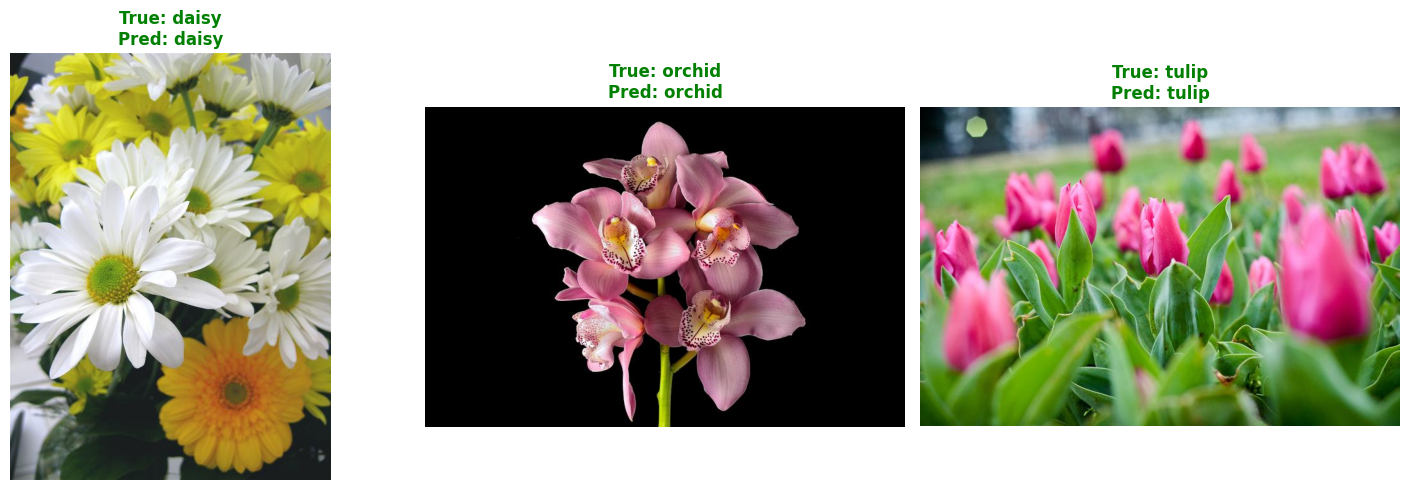


3 ẢNH DỰ ĐOÁN SAI NGẪU NHIÊN


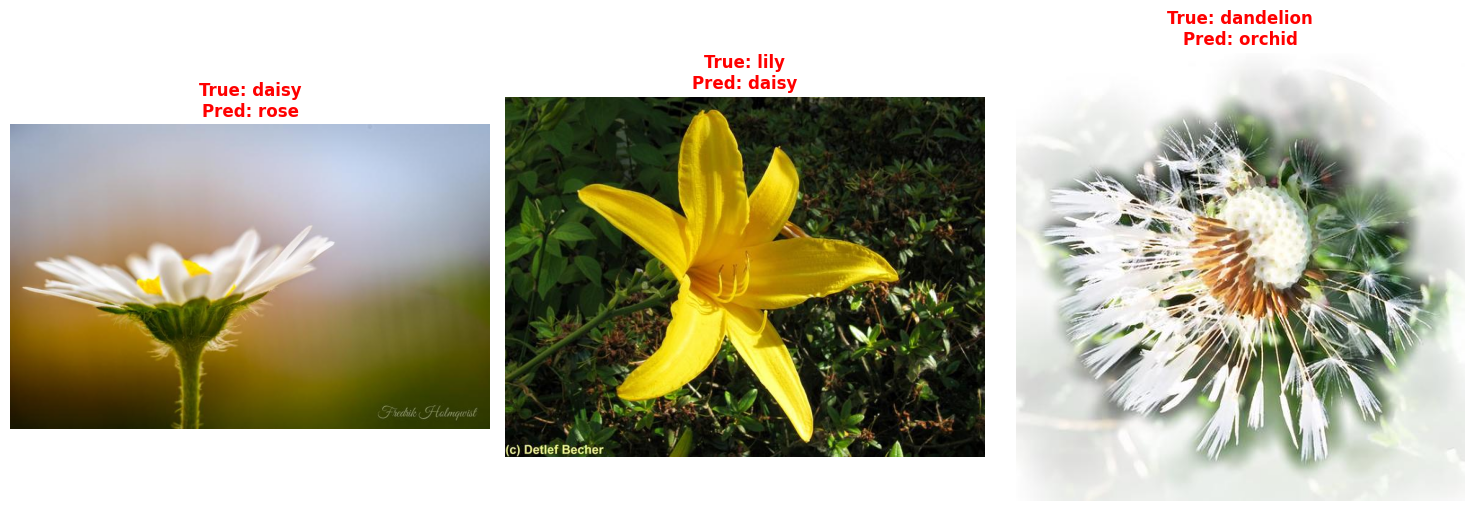

In [12]:
import numpy as np
import cv2
import os
import pickle
from pathlib import Path
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# --- I. THAM SỐ CẤU HÌNH ---
# ĐƯỜNG DẪN TỚI MODEL ĐƯỢC HUẤN LUYỆN BẰNG HOG THUẦN TÚY
MODEL_FILENAME = "final_hog_only_pca_svm_model.pkl" 

# THIẾT LẬP ĐƯỜNG DẪN DỮ LIỆU
FLOWER_DATASET_ROOT = '../flowers' 
TEST_DIR = os.path.join(FLOWER_DATASET_ROOT, 'test')


# --- II. HÀM TẢI MODEL VÀ HÀM TRÍCH XUẤT ĐẶC TRƯNG ---

def load_pipeline_components(path=MODEL_FILENAME):
    """Tải model, scaler, pca và thông số cần thiết từ file .pkl."""
    try:
        with open(path, 'rb') as f:
            data = pickle.load(f)
            return data
    except FileNotFoundError:
        print(f"🛑 Lỗi: Không tìm thấy file model tại {path}. Vui lòng kiểm tra đường dẫn.")
        return None
    except Exception as e:
        print(f"🛑 Lỗi khi tải model: {e}")
        return None

def extract_hog(img, orientations, resize_shape):
    """Trích HOG feature với tham số cố định và resize."""
    img_resized = cv2.resize(img, resize_shape)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # Giả định tham số HOG là đã được lưu trong model_data
    hog_feat = hog(
        gray,
        orientations=orientations, 
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True,
        channel_axis=None 
    )
    return hog_feat

def image_to_hog_features(img_path, model_data):
    """Đọc ảnh, resize và trích xuất CHỈ HOG (HOG thuần túy)."""
    img = cv2.imread(str(img_path))
    if img is None: return None
    img = np.ascontiguousarray(img)

    orientations = model_data['orientations']
    resize_shape = model_data['img_size']

    hog_feat = extract_hog(img, orientations=orientations, resize_shape=resize_shape)
    
    # Do model này là HOG thuần túy, KHÔNG NỐI HSV
    features = hog_feat 
    return features


# --- III. HÀM CHÍNH: PHÂN LOẠI VÀ TRỰC QUAN HÓA ---

def visualize_predictions(test_dir):
    
    # 1. Tải Model Components
    model_data = load_pipeline_components()
    if model_data is None:
        return
        
    svm_final = model_data['model']
    scaler = model_data['scaler']
    pca = model_data['pca']
    class_names = model_data['class_names']
    
    # 2. Thu thập tất cả ảnh Test
    test_dir_path = Path(test_dir)
    if not test_dir_path.is_dir():
        print(f"🛑 Lỗi: Không tìm thấy thư mục Test tại {test_dir}")
        return

    print("\n" + "="*50)
    print("Bắt đầu tìm kiếm và phân loại ảnh Test...")
    print("="*50)
    
    test_images = []
    
    # Tạo mapping nhãn (0, 1, 2...) sang tên lớp
    label_to_name = {i: name for i, name in enumerate(class_names)}
    name_to_label = {name: i for i, name in enumerate(class_names)}
    
    # Lấy danh sách ảnh test và nhãn đúng (true label)
    for cls in class_names:
        cls_dir = test_dir_path / cls
        for img_path in cls_dir.glob("*.jpg"):
            test_images.append((img_path, name_to_label[cls]))

    # 3. Dự đoán và phân loại
    correct_predictions = []
    incorrect_predictions = []
    
    # Khởi tạo LabelEncoder tạm thời để chuyển nhãn chữ sang số
    le = LabelEncoder()
    le.fit(class_names) 

    for img_path, true_label in test_images:
        
        # Trích xuất đặc trưng HOG
        feats = image_to_hog_features(img_path, model_data)
        if feats is None: continue
        
        # Áp dụng Pipeline (Scale -> PCA -> Predict)
        feats = feats.reshape(1, -1)
        feats_scaled = scaler.transform(feats)
        feats_pca = pca.transform(feats_scaled)
        
        # Dự đoán
        pred_label = svm_final.predict(feats_pca)[0]
        
        if pred_label == true_label:
            correct_predictions.append((img_path, true_label, pred_label))
        else:
            incorrect_predictions.append((img_path, true_label, pred_label))

    print(f"✅ Tổng số ảnh đã dự đoán: {len(test_images)}")
    print(f"Total correct: {len(correct_predictions)}")
    print(f"Total incorrect: {len(incorrect_predictions)}")

    # 4. Hiển thị 3 ảnh dự đoán đúng (MÀU XANH)
    if len(correct_predictions) >= 3:
        print("\n" + "="*50)
        print("3 ẢNH DỰ ĐOÁN ĐÚNG NGẪU NHIÊN")
        print("="*50)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        np.random.seed(42)
        sample_correct = np.random.choice(len(correct_predictions), 3, replace=False)
        
        for idx, sample_idx in enumerate(sample_correct):
            img_path, true_label, pred_label = correct_predictions[sample_idx]
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[idx].imshow(img_rgb)
            axes[idx].set_title(f"True: {label_to_name[true_label]}\nPred: {label_to_name[pred_label]}", 
                                color='green', fontweight='bold')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()

    # 5. Hiển thị 3 ảnh dự đoán sai (MÀU ĐỎ)
    if len(incorrect_predictions) >= 3:
        print("\n" + "="*50)
        print("3 ẢNH DỰ ĐOÁN SAI NGẪU NHIÊN")
        print("="*50)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        np.random.seed(42)
        sample_incorrect = np.random.choice(len(incorrect_predictions), 3, replace=False)
        
        for idx, sample_idx in enumerate(sample_incorrect):
            img_path, true_label, pred_label = incorrect_predictions[sample_idx]
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[idx].imshow(img_rgb)
            axes[idx].set_title(f"True: {label_to_name[true_label]}\nPred: {label_to_name[pred_label]}", 
                                color='red', fontweight='bold')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()

# --- THỰC THI ---

if __name__ == '__main__':
    if not os.path.exists(TEST_DIR):
        print("🛑 LỖI CẤU HÌNH: Vui lòng kiểm tra lại đường dẫn dataset.")
        print(f"Cần đảm bảo thư mục '{FLOWER_DATASET_ROOT}' tồn tại và chứa thư mục 'test'.")
    else:
        visualize_predictions(TEST_DIR)